# Laboratory

**Author: @THEFFTKID**

Main notebook for experimentation.

In [15]:
cd ~/downloads/Pedro-Pineapple/forecasting

/home/aargaez/downloads/Pedro-Pineapple/forecasting


In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import environments
import dataclasses
import numpy as np
import evaluation
import utils

from dynamic_threshold import define_threshold
from stable_baselines3 import A2C, PPO
from dataclasses import dataclass
from typing import List
from json import dumps

In [17]:
# Model parameters.
@dataclass
class ModelParameters:
    time_steps: int
    window_size: int
    data_path: str
    lower_threshold: float
    upper_threshold: float
    proportion: float
    features: List[str]

In [18]:
# Experiment parameters.
parameters = ModelParameters(
    time_steps=500,
    window_size=10,
    data_path='~/downloads/Pedro-Pineapple/data/SPY_20122016.csv',
    lower_threshold=.5,
    upper_threshold=.5,
    proportion=0.8,
    features= [
        'open',
        'high',
        'low',
        'volume_roc',
        'n10_rolling_mean',
        'n10_weighted_rolling_mean',
        'momentum',
        'close',
        'nday_tendency_removal'
    ]
)

In [19]:
# Read data.
data = pd.read_csv(filepath_or_buffer=parameters.data_path)
# Cast columns.
data.columns = data.columns.str.lower()

data['labels'], data['perc_relative_diff'] = evaluation.create_labels(
    x=data['close'],
    labels=[0, 1, 2],
    perc_bounds=[
        parameters.lower_threshold,
        parameters.upper_threshold
    ]
)

# Split dataset into train and test.
df_train, df_test = evaluation.data_splitter(
    raw_data=data,
    proportion=parameters.proportion
)

info {'total_reward': 361.3701849999999} 



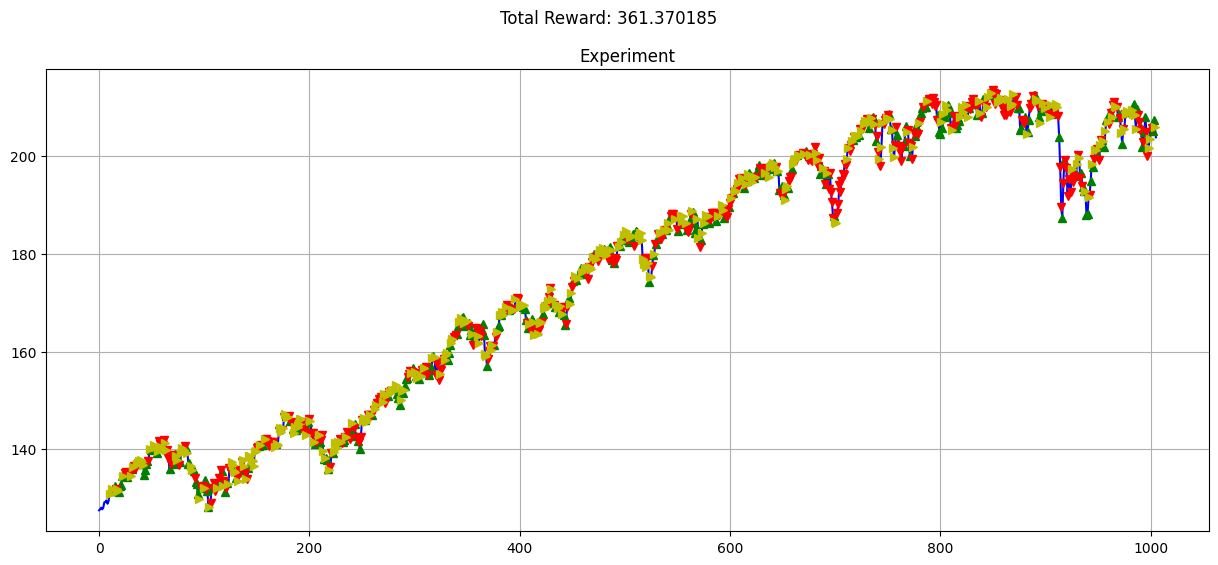

In [20]:

# Create the environment.
env = environments.Forecasting(
    df=df_train,
    window_size=parameters.window_size,
    series_features=parameters.features,
    lower_threshold=parameters.lower_threshold,
    upper_threshold=parameters.upper_threshold
)

# Random walk.
state = env.reset(seed=2008)

while True:
    # Sample action from space.
    action = env.action_space.sample()
    n_state, reward, done, truncated, info = env.step(
        action=action
    )

    if done or truncated:
        print('info', info, '\n')
        break

plt.figure(figsize=(15, 6))
plt.cla()
env.render_all(title='Experiment')
plt.show()

In [21]:
import torch as th

In [22]:
env.prices

array([127.5     , 127.699997, 128.039993, ..., 207.399994, 205.929993,
       203.869995])

In [23]:
policy_kwargs = dict(net_arch=[dict(pi=[128, 128, 128], vf=[128, 128, 128])])

In [24]:
# Train environment.
model = PPO(
    'MlpPolicy',
    env,
    verbose=1,
    policy_kwargs=policy_kwargs
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/aargaez/downloads/Pedro-Pineapple/venvpp/lib/python3.8/site-packages/stable_baselines3/common/policies.py:460: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [25]:
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Tanh()
    )
  )
  (action_net): Linear(in_features=128, out_features=3, bias=True)
  (value_net): Linear(in_f

In [26]:
# Learn.
model.learn(total_timesteps=parameters.time_steps)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 995      |
|    ep_rew_mean     | 345      |
| time/              |          |
|    fps             | 350      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------


info {'total_reward': 116.38998699999985} 



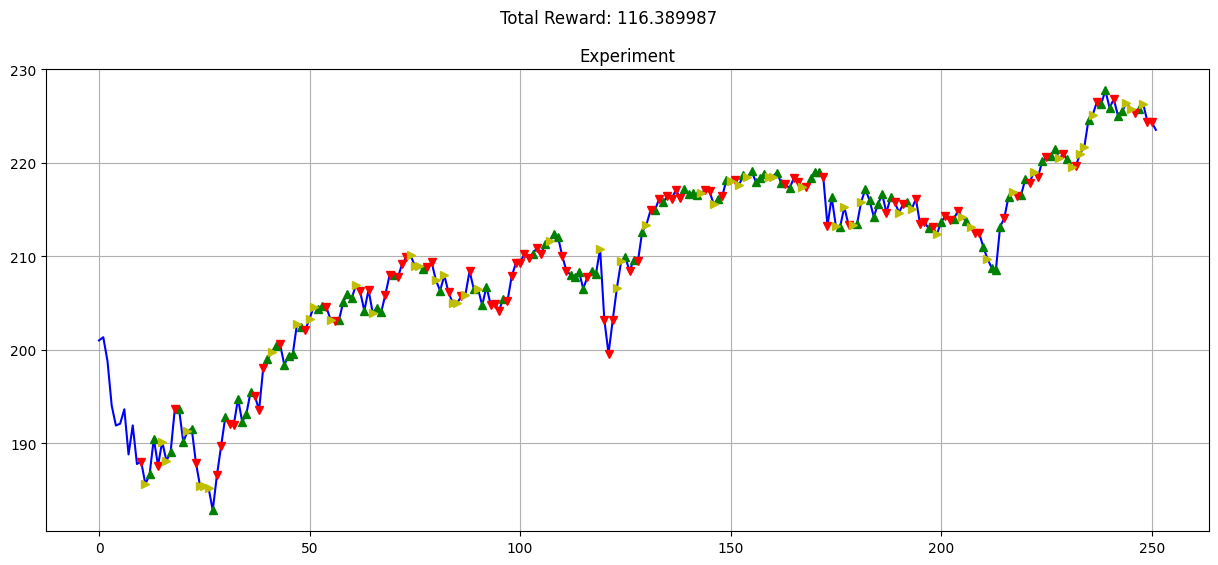

In [27]:
# Initialize a new environment with test-set.
env_test = environments.Forecasting(
    df=df_test,
    window_size=parameters.window_size,
    series_features=parameters.features,
    lower_threshold=parameters.lower_threshold,
    upper_threshold=parameters.upper_threshold
)

# Reset environment.
observation, info = env_test.reset(
    upper_threshold=env.up_threshold,
    lower_threshold=env.low_threshold
)

while True: 
    observation = observation[np.newaxis, ...]
    action, states = model.predict(observation)
    observation, rewards, done, truncated, info = env_test.step(action)
    if done or truncated:
        print('info', info, '\n')
        break

plt.figure(figsize=(15, 6))
plt.cla()
env_test.render_all(title='Experiment')
plt.show()

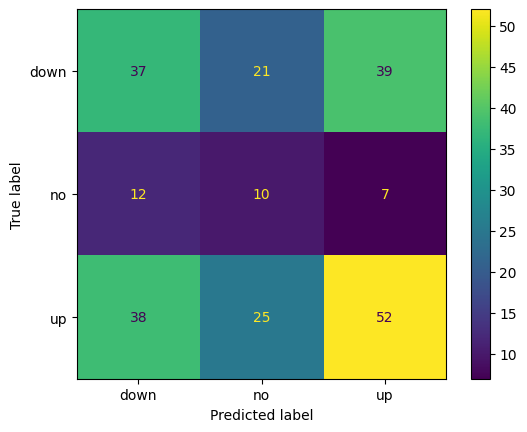

{
    "down": {
        "precision": 0.42528735632183906,
        "recall": 0.38144329896907214,
        "f1-score": 0.4021739130434782,
        "support": 97.0
    },
    "no": {
        "precision": 0.17857142857142858,
        "recall": 0.3448275862068966,
        "f1-score": 0.23529411764705882,
        "support": 29.0
    },
    "up": {
        "precision": 0.5306122448979592,
        "recall": 0.45217391304347826,
        "f1-score": 0.4882629107981221,
        "support": 115.0
    },
    "accuracy": 0.4107883817427386,
    "macro avg": {
        "precision": 0.37815700993040896,
        "recall": 0.39281493273981566,
        "f1-score": 0.3752436471628864,
        "support": 241.0
    },
    "weighted avg": {
        "precision": 0.4458583118467017,
        "recall": 0.4107883817427386,
        "f1-score": 0.4231727540197765,
        "support": 241.0
    }
}


In [28]:

y_true = df_test['labels'].to_numpy()[parameters.window_size + 1:]
y_pred = np.concatenate(env_test.actions_history)

performance = evaluation.evaluation_metrics(
    y_true=y_true,
    y_pred=y_pred,
    target_names=['down', 'no', 'up']
)

print(dumps(performance, indent=4))